# Predicting the Titanic Survival


## This is a common Machine Learning problem of Kaggle.com . It uses Ramdom Forest Classifier for Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
file_name = "train.csv"
train = pd.read_csv(file_name)

In [3]:
print(train.columns)


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


**Visual Interpretation of Data Relation**

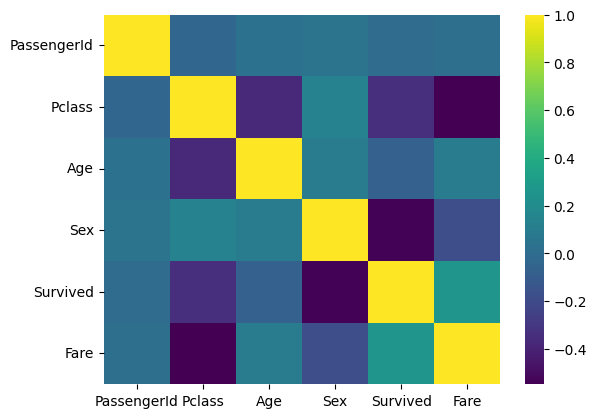

In [4]:

import seaborn as sns
selected_columns = ['PassengerId', 'Pclass',"Age","Sex", 'Survived',"Fare"]
heatmap_df = train[selected_columns].copy()
heatmap_df['Sex'] = heatmap_df['Sex'].map({'male': 1, 'female': 0})
sns.heatmap(heatmap_df.corr(),cmap="viridis")
plt.show()

In [5]:
#we will be spliting the data for train and test using shufflesplit for random split
# since random is random we need to make sure survived pclass sex data are equally distributed in both sets
#The goal is to split the dataset into training and testing sets while maintaining the same distribution of a specified set of features in both the training and testing sets.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits= 1,test_size = 0.2)
for train_indices, test_indices in split.split(train, train[["Survived","Pclass", "Sex"]]):
    strat_train = train.loc[train_indices]
    strat_test = train.loc[test_indices]
    

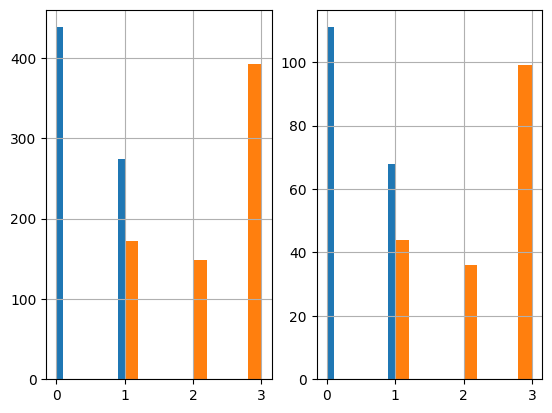

In [6]:
plt.subplot(1,2,1)
strat_train['Survived'].hist()
strat_train['Pclass'].hist()

plt.subplot(1,2,2)
strat_test['Survived'].hist()
strat_test['Pclass'].hist()
plt.show()

In [7]:
strat_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 36 to 648
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          572 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        159 non-null    object 
 11  Embarked     711 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [8]:
#The purpose of this transformer is to impute missing values in the 'Age' column of a DataFrame using the mean of the available values.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        
        imputer = SimpleImputer(strategy = "mean")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X 
                    

In [9]:
# in this Each unique category is represented by a binary column, and the presence or absence of a category is indicated by a 1 or 0, respectively.
#  If a categorical variable has n unique categories, one-hot encoding creates n binary columns.
# here for male and female we will have two columns and has the value 0 ,1 on the basis if they are female or male
# likewise 4 columns for C S Q N



from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        column_names = ["C","S","Q","N"]

        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
            
        matrix=encoder.fit_transform(X[['Sex']]).toarray()
        column_names = ["Female","Male"]

        for i in range (len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        return X
        

In [10]:
class FeatureDropper(BaseEstimator, TransformerMixin):

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")
        
    

In [11]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([("ageimputer",AgeImputer()),
                     ("featureencoder",FeatureEncoder()),
                     ("featuredropper",FeatureDropper())])

In [12]:
strat_train = pipeline.fit_transform(strat_train)

In [13]:
strat_train

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
36,37,1,3,30.158514,0,0,7.2292,1.0,0.0,0.0,0.0,1.0
675,676,0,3,18.000000,0,0,7.7750,0.0,0.0,1.0,0.0,1.0
101,102,0,3,30.158514,0,0,7.8958,0.0,0.0,1.0,0.0,1.0
486,487,1,1,35.000000,1,0,90.0000,0.0,0.0,1.0,1.0,0.0
697,698,1,3,30.158514,0,0,7.7333,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
841,842,0,2,16.000000,0,0,10.5000,0.0,0.0,1.0,0.0,1.0
470,471,0,3,30.158514,0,0,7.2500,0.0,0.0,1.0,0.0,1.0
670,671,1,2,40.000000,1,1,39.0000,0.0,0.0,1.0,1.0,0.0
347,348,1,3,30.158514,1,0,16.1000,0.0,0.0,1.0,1.0,0.0


In [14]:
strat_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 36 to 648
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [15]:
from sklearn.preprocessing import StandardScaler

X = strat_train.drop(["Survived"], axis = 1)
Y = strat_train['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = Y.to_numpy()


In [16]:
X_data.shape

(712, 11)

In [17]:
X_data

array([[-1.58598103e+00,  8.27893418e-01, -2.75844256e-16, ...,
        -1.60558072e+00, -7.35612358e-01,  7.35612358e-01],
       [ 9.01713128e-01,  8.27893418e-01, -9.44026608e-01, ...,
         6.22827609e-01, -7.35612358e-01,  7.35612358e-01],
       [-1.33292920e+00,  8.27893418e-01, -2.75844256e-16, ...,
         6.22827609e-01, -7.35612358e-01,  7.35612358e-01],
       ...,
       [ 8.82247602e-01, -3.70196244e-01,  7.64125013e-01, ...,
         6.22827609e-01,  1.35941164e+00, -1.35941164e+00],
       [-3.75225342e-01,  8.27893418e-01, -2.75844256e-16, ...,
         6.22827609e-01,  1.35941164e+00, -1.35941164e+00],
       [ 7.96599290e-01,  8.27893418e-01, -2.75844256e-16, ...,
         6.22827609e-01, -7.35612358e-01,  7.35612358e-01]])

In [18]:
y_data

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()
param_grid = [
    {"n_estimators":[10,100,200,500], 
     "max_depth" : [None, 5, 10],
     "min_samples_split":[2,3,4]
    }
]

grid_search = GridSearchCV(clf,param_grid,cv=3,scoring="accuracy", return_train_score=True)
grid_search.fit(X_data,y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [20]:
#to check which was our best estimators
final_clf = grid_search.best_estimator_
final_clf

RandomForestClassifier(max_depth=10, min_samples_split=4)

In [21]:
strat_test = pipeline.fit_transform(strat_test)


In [22]:
X_test = strat_test.drop(['Survived'],axis=1)
y_test = strat_test['Survived']

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [23]:
final_clf.score(X_data_test,y_data_test)

0.8044692737430168

In [24]:
final_data = pipeline.fit_transform(train)

In [25]:
X_final = final_data.drop(['Survived'], axis = 1)
Y_final = final_data['Survived']

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = Y_final.to_numpy() 

In [26]:
prod_clf = RandomForestClassifier()
param_grid = [
    {"n_estimators":[10,100,200,500], 
     "max_depth" : [None, 5, 10],
     "min_samples_split":[2,3,4]
    }
]

grid_search = GridSearchCV(prod_clf,param_grid,cv=3,scoring="accuracy", return_train_score=True)
grid_search.fit(X_data_final,y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [27]:
prod_final_clf = grid_search.best_estimator_

In [28]:
prod_final_clf

RandomForestClassifier(max_depth=10)

**Now our Model is ready . We Predict the value for test.csv**

In [30]:
test_data = pd.read_csv("test.csv")

In [31]:
final_test_data = pipeline.fit_transform(test_data)

In [35]:
final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   S            418 non-null    float64
 8   Q            418 non-null    float64
 9   Female       418 non-null    float64
 10  Male         418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.0 KB


In [39]:
X_final_test = final_test_data
X_final_test = X_final_test.ffill()

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

In [40]:
predictions = prod_final_clf.predict(X_data_final_test)

In [41]:
predictions 

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [43]:
prediction_df = pd.DataFrame(test_data["PassengerId"])
prediction_df["Survived"] = predictions
prediction_df.to_csv("Prediction.csv",index=False)
# index set to false so we dont have a index column 

In [44]:
prediction_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
